In [1]:
##################################
### Import the usual libraries ###
##################################

#numpy
import numpy as np

# scipy
from scipy.stats import binned_statistic

#astropy
import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column, QTable

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

# Yumi's Code to convert (RA,DEC) to MS coordinates
import MagellanicStream as ms

# .py files for grad calc
import astrofunctions as astro
import lmcgeometry as lgeo
import mlefitting as mle
import utilities as util

# Ignore warnings unless crashes
import warnings
warnings.filterwarnings('ignore')

#progress bars
from tqdm import tqdm_notebook

In [2]:
# PARSEC Isochrones
parsecall = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3_3.dat',format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

# LMC lmc data
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-9999.0)&(lmc['LOGG']>0.0)&
                (lmc['M_H_ERR']>-90.0)&(lmc['C_FE']>-9999.0)&(lmc['N_FE']>-9999.0))

lmc = lmc[cln]

In [3]:
### AGB Cut
left = parsec[np.where(parsec['MH']==min(parsec['MH']))]
middle = parsec[np.where(parsec['MH']==-1.115)]
right = parsec[np.where(parsec['MH']==max(parsec['MH']))]

gravs = [min(left['logg'])-0.03,min(middle['logg']),min(right['logg'])-0.015]

teffs = [max(10**left[np.where(left['logg']==min(left['logg']))]['logTe']),
         min(10**middle[np.where(middle['logg']==min(middle['logg']))]['logTe']),
         min(10**right[np.where(right['logg']==min(right['logg']))]['logTe'])]

zagb = np.polyfit(teffs, gravs, 3)
pagb = np.poly1d(zagb)

agb_cut = np.where(lmc['LOGG']>pagb(lmc['TEFF']))

### Bloop Cut
kmags = [0.7,1.]
colos = [13.5,12.]

zbloop = np.polyfit(kmags, colos, 1)
pbloop = np.poly1d(zbloop)

bloop_cut = np.where(lmc[agb_cut]['K']>pbloop(lmc[agb_cut]['J']-lmc[agb_cut]['K'])+0.1)

lmc_nobloop_noagb = lmc[agb_cut][bloop_cut]

In [ ]:
# plt.figure(figsize=[10,10])
# plt.scatter((lmc['J']-lmc['K']),lmc['K'],c='k')
# plt.scatter((lmc['J']-lmc['K'])[agb_cut],lmc['K'][agb_cut],c='r',alpha=0.5)
# # plt.axhline(12.5,c='k')

# plt.gca().invert_yaxis()

# plt.xlabel(r'J - K')
# plt.ylabel(r'K')
# plt.title(r'AGB Cut')

# plt.show()

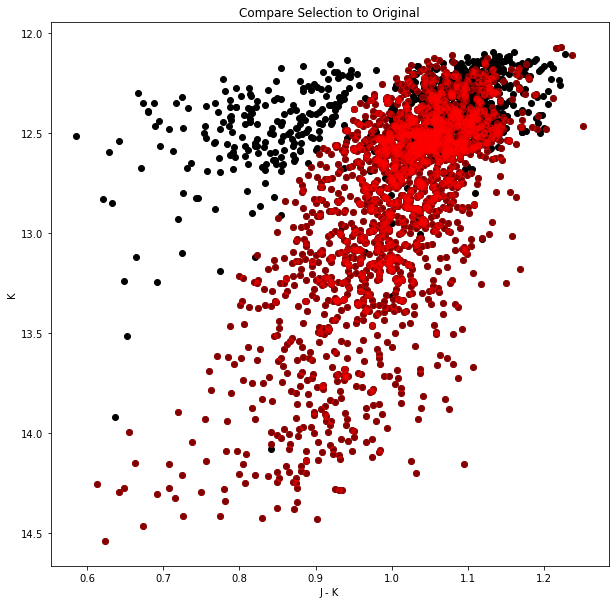

In [4]:
plt.figure(figsize=[10,10])
plt.scatter((lmc['J']-lmc['K']),lmc['K'],c='k')
plt.scatter((lmc_nobloop_noagb['J']-lmc_nobloop_noagb['K']),lmc_nobloop_noagb['K'],c='r',alpha=0.5)

plt.gca().invert_yaxis()

plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.title(r'Compare Selection to Original')

plt.show()

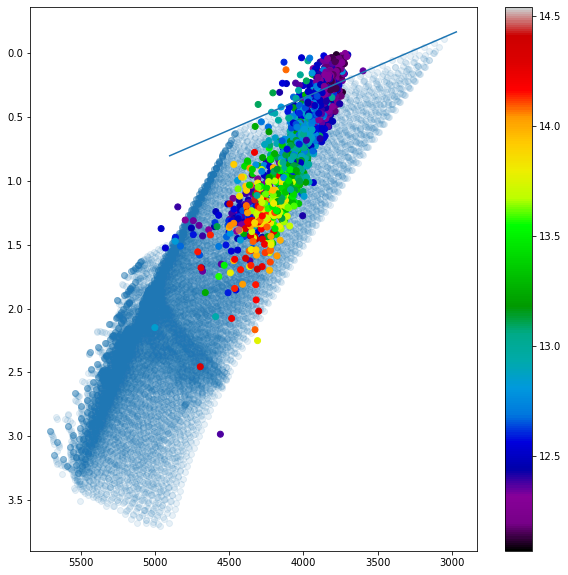

In [5]:
plt.figure(figsize=[10,10])
plt.scatter(10**parsec['logTe'],parsec['logg'],alpha=0.1)#,c=parsec['MH'])
# plt.colorbar()
# plt.scatter(10**parsecall[agb]['logTe'],parsecall['logg'][agb],c=parsecall['MH'][agb])
plt.scatter(lmc['TEFF'],lmc['logg'],c=lmc['K'],vmin=min(lmc['K']),cmap='nipy_spectral')
plt.colorbar()

plt.plot([2970,4900],[pagb(2970),pagb(4900)])
# plt.axhline(12.5,c='k')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

maybe try the PARSEC shift mentioned in Ashok et al. 2021 and then cut everything above?